/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Number of relevant pixels =  477


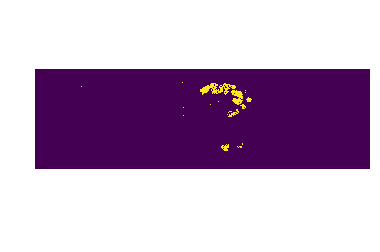

In [1]:
# COMPUTES TFIDF MEASURES OF IONS IN A REGION AS COMPARED TO PIXELS OUTSIDE OF THE REGION

# SET SUMFORMULA NAME, ADDUCT, DATASET for selecting the region
sf = 'C26H45NO7S'
adduct = '+Na'
ds_name = 'wb xenograft in situ metabolomics test - rms_corrected'

# model param : tfidf or lsi or corpus
model = "corpus"
# quantile param
q = 70.

import os
from os import path
import pandas as pd
import gensim
from gensim import corpora
import pickle
import numpy as np

base_path = '/opt/data/'
ann_path = path.join(base_path, 'pixel-annot-export')
cor_path = path.join(base_path, 'pixel-corpora/pixel_'+model+'.mm')
map_path = path.join(base_path, 'pixel-ind2ord')

ds_df_path = path.join(ann_path, 'ds_df.msgpack')
ds_df = pd.read_msgpack(ds_df_path)
ds_ind = ds_df[ds_df['name'] == ds_name].index.tolist()[0]

ion_df_path = path.join(ann_path, 'ion_df.msgpack')
ion_df = pd.read_msgpack(ion_df_path)
ion_ind = ion_df[ion_df.formula == sf][ion_df.adduct == adduct].index.tolist()[0]

pind2ord_path = path.join(map_path, '{}.pkl'.format(ds_ind))
with open(pind2ord_path, 'rb') as f: pind2ord = pickle.load(f)

pixel_df_path = path.join(ann_path, 'pixel_df_list/{}.msgpack'.format(ds_ind))
pixel_df = pd.read_msgpack(pixel_df_path)

int = np.percentile(pixel_df.int.tolist(), q)
ion_sub_df = pixel_df[(pixel_df.ion_ind == ion_ind) & (pixel_df.int > int)]
ion_unique_pix = ion_sub_df.p_ind.unique()
region_pixel_ids = [pind2ord[i] for i in ion_unique_pix if i in pind2ord]

print('Number of relevant pixels = ', len(region_pixel_ids))

%matplotlib inline
import matplotlib.pyplot as plt

max_x = pixel_df['x'].max()
max_y = pixel_df['y'].max()
arr = np.zeros([max_x+1, max_y+1])

for index, row in ion_sub_df.iterrows():
    arr[row['x'].astype(np.int64)][row['y'].astype(np.int64)] = 1
arr = np.rot90(arr, 1)

plt.pcolormesh(arr,cmap='viridis')
plt.axes().set_aspect('equal', 'datalim')
plt.axes().axis('off')
plt.show()

In [2]:
import gensim
from gensim import corpora
from gensim import models

extra_region_pixel_ids = [pind2ord[i] for i in pixel_df.p_ind.unique() if i not in ion_unique_pix and i in pind2ord]

corpus = gensim.corpora.MmCorpus(cor_path)

ions2values = {}
for pix_id in region_pixel_ids:
    for (ion_id,value) in corpus[pix_id]:
        if not ion_id in ions2values: ions2values[ion_id] = []
        ions2values[ion_id].append(value)

region_corpus = [(ion_id, np.mean(ions2values[ion_id])) for ion_id in ions2values]
new_corpus = [corpus[i] for i in extra_region_pixel_ids]
new_corpus.append(region_corpus)

dictionary = {idx : row['formula']+row['adduct'] for idx, row in ion_df.iterrows()}

tfidf_model = gensim.models.TfidfModel(new_corpus, id2word = dictionary)
tfidf_corpus = tfidf_model[new_corpus]
mod_region_corpus = tfidf_corpus[-1]
mod_region_corpus.sort(key=lambda x: x[1],reverse=True)

In [3]:
def hotspot_removal(img):
    perc99_v = np.percentile(img, q=99.9)
    img[img > perc99_v] = perc99_v
    return img

C26H45NO7S +K: 0.518029


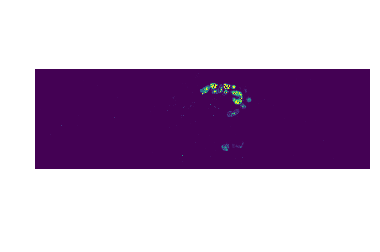

C26H45NO7S +Na: 0.506547


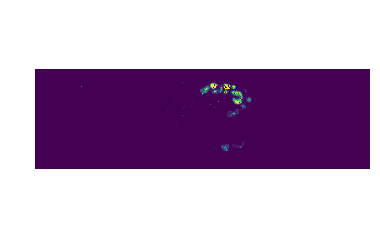

C27H40O8 +H: 0.261134


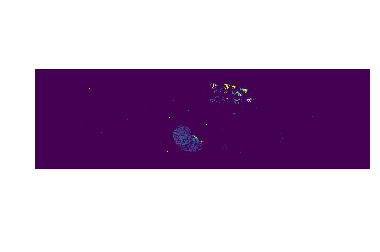

C31H33N3O7S +H: 0.255124


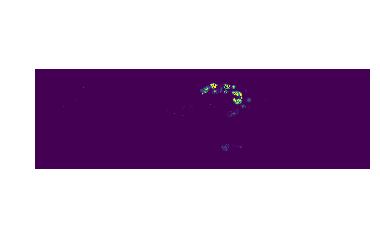

C24H29NO9 +H: 0.211120


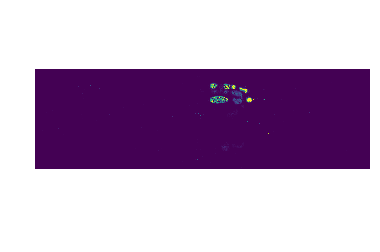

C12H24N4O7 +H: 0.197832


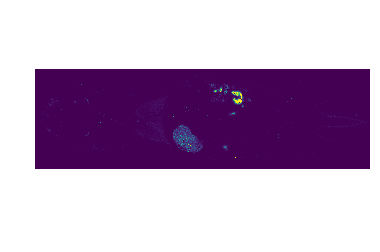

C27H32O5 +K: 0.164210


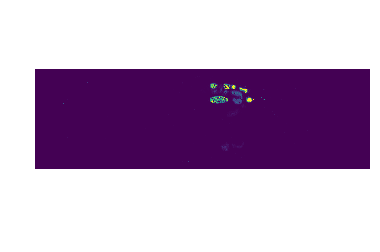

C25H32O10 +H: 0.162366


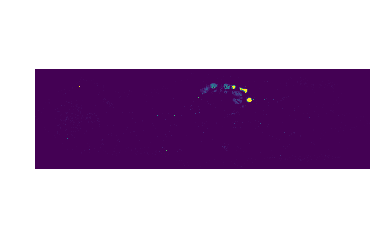

C16H21N3O2 +H: 0.159599


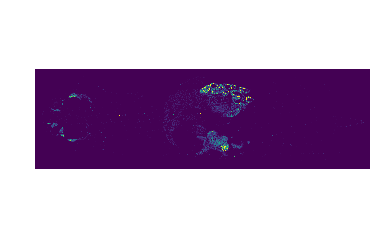

C16H18N6O5 +Na: 0.141966


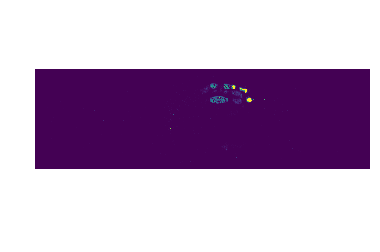

C18H34N4O12 +H: 0.127988


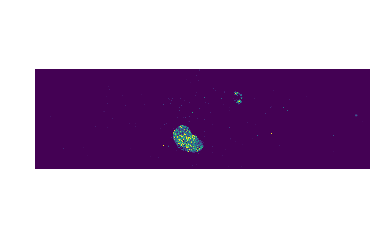

C18H32O16 +Na: 0.117844


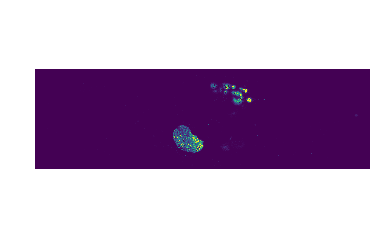

C26H48NO7P +H: 0.113258


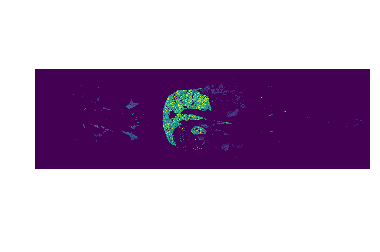

C12H24N2O3 +H: 0.109399


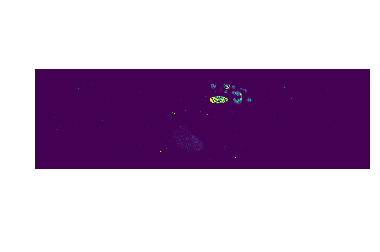

C23H30O2 +Na: 0.107322


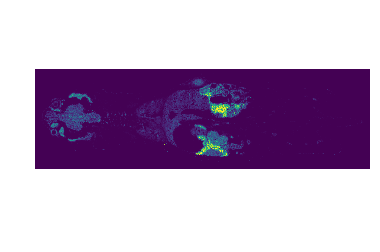

C27H42O8 +H: 0.105336


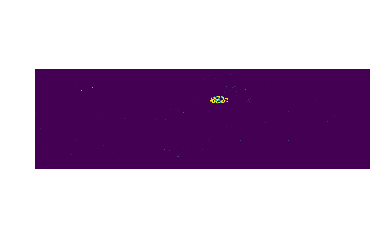

C21H21NO6 +Na: 0.087711


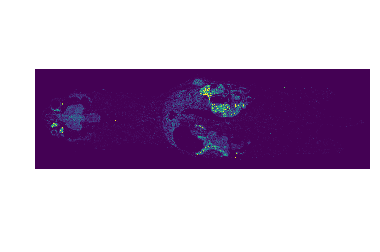

C24H47NO4 +H: 0.084245


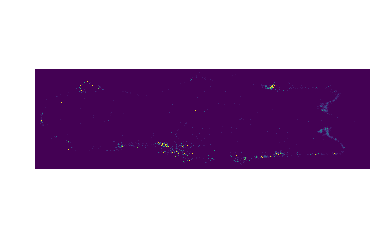

C23H44NO7P +H: 0.082629


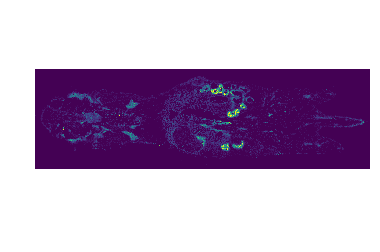

C28H48NO7P +H: 0.075252


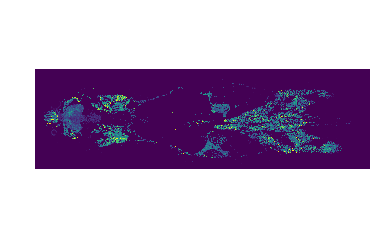

C20H32N6O12S2 +H: 0.060637


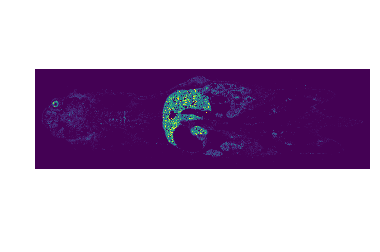

C16H28O11 +H: 0.057986


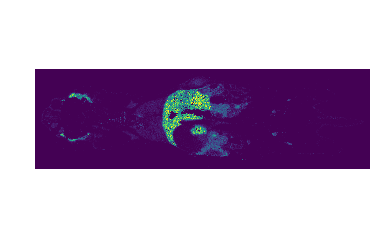

C37H66O4 +H: 0.056418


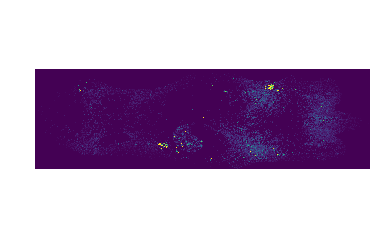

C19H27NO3 +H: 0.049720


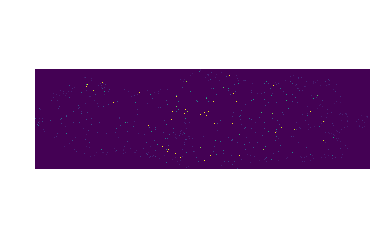

C11H12N2O +H: 0.048550


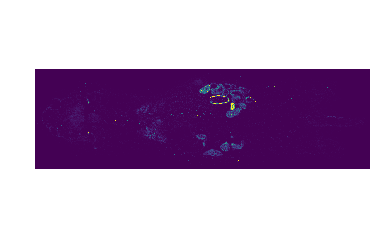

C15H23N3O3 +H: 0.047144


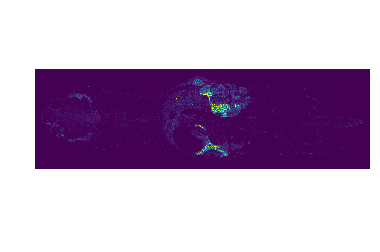

C28H52NO7P +H: 0.043911


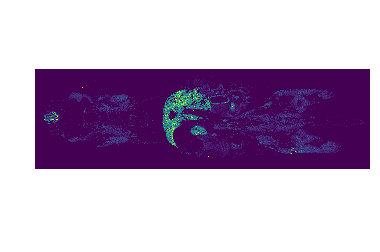

C23H46NO7P +Na: 0.041869


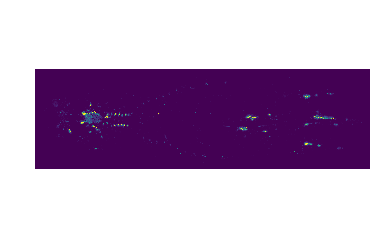

C14H30O4S +Na: 0.041144


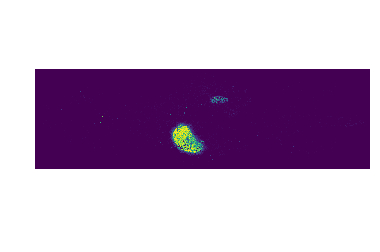

C32H49NO5 +Na: 0.037645


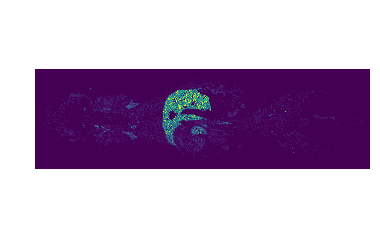

C15H30O5 +H: 0.036978


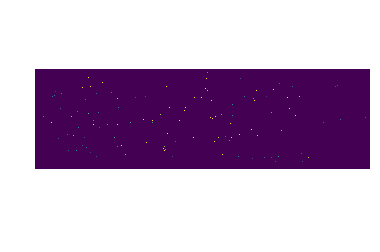

C14H17N5O8 +H: 0.035091


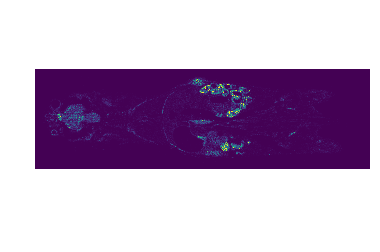

C14H20N6O5S +H: 0.033880


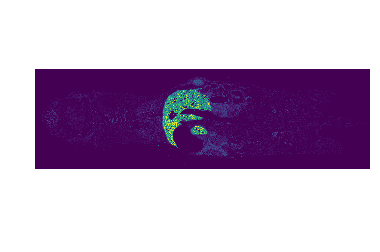

C10H9NO +H: 0.032633


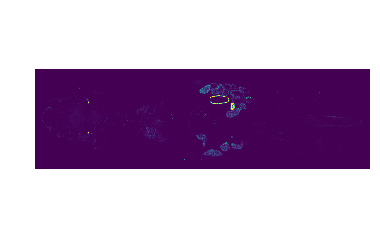

C5H4N4O +Na: 0.032359


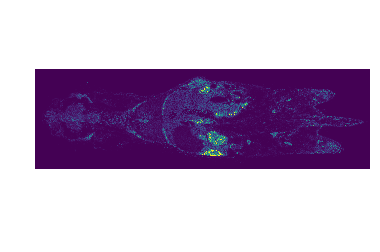

C35H66O4 +H: 0.030717


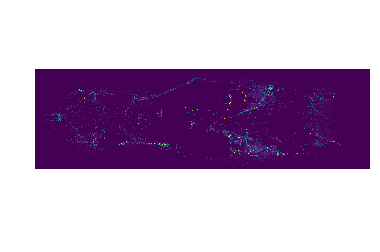

C10H12N4O5 +H: 0.028768


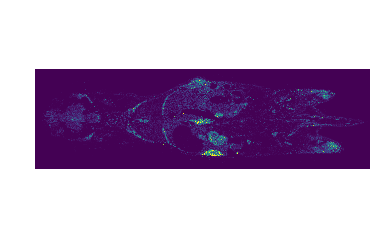

C19H24O4 +H: 0.028755


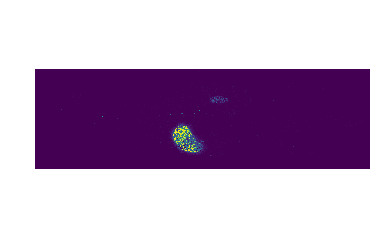

C15H18O10 +Na: 0.027923


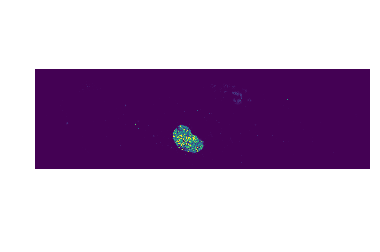

C26H50NO7P +Na: 0.027534


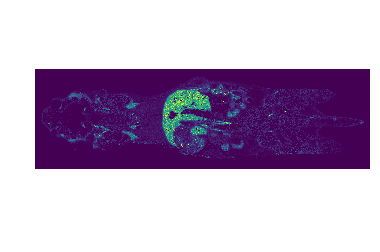

In [4]:
# THRESHOLD FOR MOST CHARACTRISTIC IONS
t = 0.0000005
# NUMBER OF MOST CHARACTRISTIC IONS
n = 40

counter = 0
csv_ions = []
for (ion_ind,value) in mod_region_corpus:
    if counter == n or value<t: break
    counter+=1
    print('%s %s: %f' % (ion_df.at[ion_ind,'formula'], ion_df.at[ion_ind,'adduct'], value))
    csv_ions.append('%s,%s,%f' % (ion_df.at[ion_ind,'formula'], ion_df.at[ion_ind,'adduct'], value))
    
    ion_sub_df = pixel_df[pixel_df.ion_ind == ion_ind]
    
    max_x = pixel_df['x'].max()
    max_y = pixel_df['y'].max()
    arr = np.zeros([max_x+1, max_y+1])
    
    for p_ind in ion_sub_df.p_ind.unique():
        rel_row = ion_sub_df[ion_sub_df.p_ind == p_ind]
        arr[rel_row.x.values[0]][rel_row.y.values[0]] = rel_row.int.values[0]
        
    arr = np.rot90(arr, 1)
    arr = hotspot_removal(arr)
    plt.pcolormesh(arr,cmap='viridis')
    plt.axes().set_aspect('equal', 'datalim')
    plt.axes().axis('off')
    plt.show()

In [40]:
for e in csv_ions: print(e)

C26H45NO7S,+K,0.587667
C26H45NO7S,+Na,0.553519
C27H40O8,+H,0.224862
C24H29NO9,+H,0.213707
C12H24N4O7,+H,0.194785
C16H21N3O2,+H,0.188370
C27H32O5,+K,0.174720
C31H33N3O7S,+H,0.170472
C16H18N6O5,+Na,0.140104
C25H32O10,+H,0.108000
C21H21NO6,+Na,0.099909
C27H42O8,+H,0.098799
C23H30O2,+Na,0.093117
C18H34N4O12,+H,0.083756
C24H47NO4,+H,0.073740
C23H44NO7P,+H,0.065642
C18H32O16,+Na,0.057805
C26H48NO7P,+H,0.056458
C15H30O5,+H,0.054017
C20H32N6O12S2,+H,0.049824
C19H27NO3,+H,0.049486
C12H24N2O3,+H,0.047385
C11H12N2O,+H,0.044309
C16H28O11,+H,0.043224
C15H23N3O3,+H,0.043176
C28H48NO7P,+H,0.037839
C9H12FN2O9P,+Na,0.033736
C23H46NO7P,+Na,0.032601
C21H20O8,+H,0.032227
C14H17N5O8,+H,0.032068
C14H20N6O5S,+H,0.026718
C32H49NO5,+Na,0.026405
C10H9NO,+H,0.025848
C14H30O4S,+Na,0.025715
C5H4N4O,+Na,0.025267
C28H52NO7P,+H,0.022728
C19H24O4,+H,0.022064
C15H24O7,+H,0.021351
C37H66O4,+H,0.020733
C5H7NO3,+Na,0.020460
